In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import target_encoding as te
import gc

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 
import time

#Images
import zipfile

In [2]:
train_df = pd.read_csv("../data/train.csv", parse_dates=["activation_date"])#, nrows=1000)
test_df = pd.read_csv("../data/test.csv", parse_dates=["activation_date"])#, nrows=1000)
aggregated_features = pd.read_csv("../data/aggregated_features.csv")
#periods_train = pd.read_csv("../data/periods_train.csv", parse_dates=["activation_date", "date_from", "date_to"])#, nrows=1000)
#periods_test = pd.read_csv("../data/periods_test.csv", parse_dates=["activation_date", "date_from", "date_to"])#, nrows=1000)
#train_active = pd.read_csv("../data/train_active.csv", parse_dates=["activation_date"], nrows=1000)
#test_active = pd.read_csv("../data/test_active.csv", parse_dates=["activation_date"], nrows=1000)
trainindex = train_df.index
testindex = test_df.index
test_id = test_df["item_id"].values
print("Train file rows and columns are : ", train_df.shape)
print("Test file rows and columns are : ", test_df.shape)


Train file rows and columns are :  (1503424, 18)
Test file rows and columns are :  (508438, 17)


In [3]:
train_y = train_df.deal_probability.copy()
train_df.drop("deal_probability",axis=1, inplace=True)
train_df['param_1_enc'] = train_df['param_1']
train_df['param_2_enc'] = train_df['param_2']
train_df['param_3_enc'] = train_df['param_3']
test_df['param_1_enc'] = test_df['param_1']
test_df['param_2_enc'] = test_df['param_2']
test_df['param_3_enc'] = test_df['param_3']

In [4]:
# Calculate concurrent offers
#def calc_conc(df):
    

In [5]:
# Target encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1_enc", "param_2_enc", "param_3_enc", "image_top_1"]
for col in cat_vars:
    train_df[col], test_df[col] = te.target_encode(train_df[col], test_df[col], train_y, min_samples_leaf=100, smoothing=10, noise_level=0.01)
    #lbl = preprocessing.LabelEncoder()
    #lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    #train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    #test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))


In [6]:
# Combine train and test for preprocessing
df = pd.concat([train_df,test_df],axis=0)
del train_df, test_df
gc.collect()

df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,param_1_enc,param_2_enc,param_3_enc
0,b912c3c6a6ad,e00f8ff2eaf9,0.123248,0.123683,0.075811,0.201666,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,0.150009,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,0.089594,0.091117,0.137810,0.138346
1,2dac0150717d,39aeb48f0017,0.135167,0.138589,0.179753,0.189865,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,0.149428,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,0.158635,0.126114,0.138222,0.139277
2,ba83aefab5dc,91e2f88dd6e3,0.137415,0.125686,0.172651,0.172790,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,0.147713,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,0.201978,0.124210,0.138682,0.139101
3,02996f1dd2ea,bf5cccea572d,0.141961,0.133870,0.076091,0.198892,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,0.121776,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,0.335026,0.332666,0.137865,0.137163
4,7c90be56d2ab,ef50846afc0b,0.145373,0.136550,0.263151,0.275100,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,0.147705,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,0.318941,0.284132,0.358193,0.372894


In [7]:
df = df.merge(aggregated_features, on=['user_id'], how='left')
del aggregated_features
gc.collect()
df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,activation_date,user_type,image,image_top_1,param_1_enc,param_2_enc,param_3_enc,avg_days_up_user,avg_times_up_user,n_user_items
0,b912c3c6a6ad,e00f8ff2eaf9,0.123248,0.123683,0.075811,0.201666,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),...,2017-03-28,0.150009,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,0.089594,0.091117,0.137810,0.138346,8.000000,2.000000,2
1,2dac0150717d,39aeb48f0017,0.135167,0.138589,0.179753,0.189865,Другое,NaN,NaN,Стойка для Одежды,...,2017-03-26,0.149428,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,0.158635,0.126114,0.138222,0.139277,NaN,NaN,1
2,ba83aefab5dc,91e2f88dd6e3,0.137415,0.125686,0.172651,0.172790,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,...,2017-03-20,0.147713,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,0.201978,0.124210,0.138682,0.139101,4.428571,1.142857,9
3,02996f1dd2ea,bf5cccea572d,0.141961,0.133870,0.076091,0.198892,Автомобильные кресла,NaN,NaN,Автокресло,...,2017-03-25,0.121776,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,0.335026,0.332666,0.137865,0.137163,16.714286,2.642857,32
4,7c90be56d2ab,ef50846afc0b,0.145373,0.136550,0.263151,0.275100,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",...,2017-03-16,0.147705,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,0.318941,0.284132,0.358193,0.372894,NaN,NaN,1


In [8]:
# Simple Feature Engineering

# Time Data
df["activation_weekday"] = df["activation_date"].dt.weekday
#df["activation_monthday"] = df["activation_date"].dt.day

# Price
## Replace Nan with mean in price
#categories = df.category_name.unique()
#region = df.region.unique()
#param1 = df.param_1.unique()
#
#
#df["price_new"] = df["price"].values
#
#for cat in categories:
#    for reg in region:
#        cur_df = df.loc[(df["category_name"] == cat)  & (df["region"] == reg)]["price_new"]
#        cur_df.fillna(np.nanmean(cur_df.values), inplace=True)
#
#
#df["price"] = pd.isna(df["price"])
df["price"] = np.log(df["price"]+1)
df["price"].fillna(0, inplace=True)
df["image_top_1"].fillna(0, inplace=True)
df['param_1'].fillna("", inplace = True)
df['param_2'].fillna("", inplace = True)
df['param_3'].fillna("", inplace = True)



#Drop Cols
cols_to_drop = ["item_id", "user_id", "activation_date", "image"]
df.drop(cols_to_drop, axis=1,inplace=True)

In [9]:
# Image Featues
df.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,user_type,image_top_1,param_1_enc,param_2_enc,param_3_enc,avg_days_up_user,avg_times_up_user,n_user_items,activation_weekday
0,0.123248,0.123683,0.075811,0.201666,Постельные принадлежности,,,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",5.993961,2,0.150009,0.089594,0.091117,0.137810,0.138346,8.000000,2.000000,2,1
1,0.135167,0.138589,0.179753,0.189865,Другое,,,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",8.006701,19,0.149428,0.158635,0.126114,0.138222,0.139277,NaN,NaN,1,6
2,0.137415,0.125686,0.172651,0.172790,"Видео, DVD и Blu-ray плееры",,,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",8.294300,9,0.147713,0.201978,0.124210,0.138682,0.139101,4.428571,1.142857,9,0
3,0.141961,0.133870,0.076091,0.198892,Автомобильные кресла,,,Автокресло,Продам кресло от0-25кг,7.696667,286,0.121776,0.335026,0.332666,0.137865,0.137163,16.714286,2.642857,32,5
4,0.145373,0.136550,0.263151,0.275100,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,10.596660,3,0.147705,0.318941,0.284132,0.358193,0.372894,NaN,NaN,1,3


In [10]:
# Text Features
df['text_feat'] = df.apply(lambda row: ' '.join([
    str(row['param_1']), 
    str(row['param_2']), 
    str(row['param_3'])]),axis=1) # Group Param Features
df.drop(['param_1', 'param_2', 'param_3'], axis = 1, inplace=True)

# Meta Text Features
textfeats = ["description", "text_feat", "title"]
for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('empty') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words

In [11]:
out_df = df.head(trainindex.shape[0])
out_df['deal_probability']= train_y
out_df.head()
out_df.to_csv('dataframe_text_features.csv')

/home/jonasprobst/miniconda3/envs/py35_knime/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [12]:
print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}
def get_col(col_name): return lambda x: x[col_name]
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=16000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('text_feat',CountVectorizer(
            ngram_range=(1, 2),
            #max_features=7000,
            preprocessor=get_col('text_feat'))),
        ('title',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])
    
start_vect=time.time()
vectorizer.fit(df.loc[trainindex,:].to_dict('records'))
ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
df.drop(textfeats, axis=1,inplace=True)


[TF-IDF] Term Frequency Inverse Document Frequency Stage
Vectorization Runtime: 7.41 Minutes


In [13]:
train_X = hstack([csr_matrix(df.head(trainindex.shape[0]).values),ready_df[0:trainindex.shape[0]]]) # Sparse Matrix
test_X = hstack([csr_matrix(df.tail(testindex.shape[0]).values),ready_df[trainindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [train_X,test_X]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

1503424 Rows and 1186161 Cols
508438 Rows and 1186161 Cols
Feature Names Length:  1186161


In [14]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y, feature_name=tfvocab)
    lgval = lgb.Dataset(val_X, label=val_y, feature_name=tfvocab)
    evals_result = {}
    model = lgb.train(params, lgtrain, 16000, valid_sets=[lgval], early_stopping_rounds=500, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [15]:

# Splitting the data for model training#
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=42)


# Training the model #
pred_test, model, evals_result = run_lgb(X_train, y_train, X_val, y_val, test_X)

# Making a submission file #
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv("tfidf_aggregated_features_lgb.csv", index=False)

Training until validation scores don't improve for 500 rounds.
[20]	valid_0's rmse: 0.22983
[40]	valid_0's rmse: 0.226913
[60]	valid_0's rmse: 0.22556
[80]	valid_0's rmse: 0.224713
[100]	valid_0's rmse: 0.224151
[120]	valid_0's rmse: 0.223743
[140]	valid_0's rmse: 0.223423
[160]	valid_0's rmse: 0.223161
[180]	valid_0's rmse: 0.222956
[200]	valid_0's rmse: 0.222783
[220]	valid_0's rmse: 0.222611
[240]	valid_0's rmse: 0.222469
[260]	valid_0's rmse: 0.222349
[280]	valid_0's rmse: 0.222244
[300]	valid_0's rmse: 0.222147
[320]	valid_0's rmse: 0.222009
[340]	valid_0's rmse: 0.221935
[360]	valid_0's rmse: 0.221877
[380]	valid_0's rmse: 0.221794
[400]	valid_0's rmse: 0.221727
[420]	valid_0's rmse: 0.221656
[440]	valid_0's rmse: 0.221609
[460]	valid_0's rmse: 0.221544
[480]	valid_0's rmse: 0.221498
[500]	valid_0's rmse: 0.221449
[520]	valid_0's rmse: 0.221411
[540]	valid_0's rmse: 0.22136
[560]	valid_0's rmse: 0.22134
[580]	valid_0's rmse: 0.221307
[600]	valid_0's rmse: 0.221278
[620]	valid_0's

/home/jonasprobst/miniconda3/envs/py35_knime/lib/python3.5/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


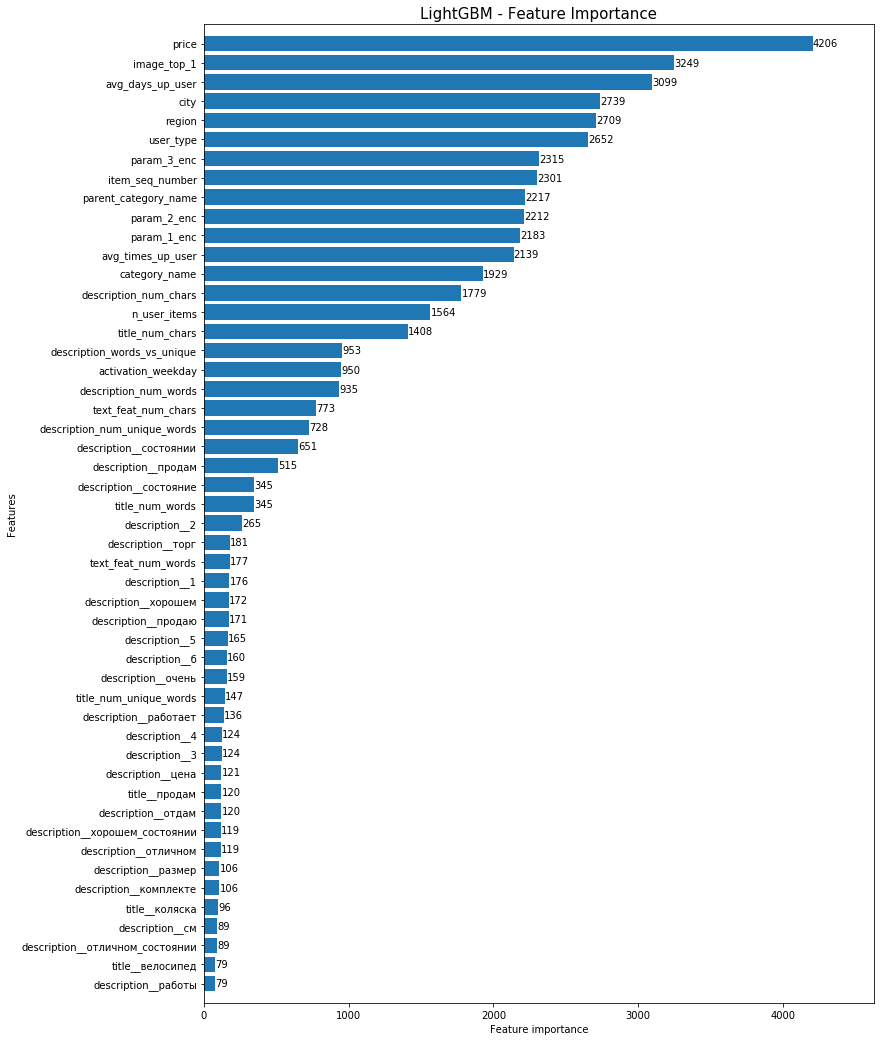

In [16]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()